In [117]:
import pandas as pd
import missingno as msno
import seaborn as sns
import re
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams, trigrams
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/sunnypzz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sunnypzz/nltk_data...


True

In [101]:
df = pd.read_csv('dataset/complaints.csv', encoding = 'unicode_escape')
df.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,6/1/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,FactorTrust run by XXXX have another consumer ...,None,Factor Trust,OH,44708,None,Consent provided,Web,6/1/23,Closed with explanation,Yes,NaN,7059212
1,6/1/23,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,"To Whom It May Concern, I purchased an XXXX a...",None,GOLDMAN SACHS BANK USA,CA,92308,Older American,Consent provided,Web,6/1/23,Closed with explanation,Yes,NaN,7059423
2,6/1/23,Mortgage,Conventional home mortgage,Trouble during payment process,None,"Hello, My name is XXXX XXXX. \n\nI am trying t...",None,SN SERVICING CORPORATION,MD,208XX,Older American,Consent provided,Web,6/1/23,Closed with explanation,Yes,NaN,7055447
3,6/1/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,n accordance with the fair credit Reporting ac...,None,"EQUIFAX, INC.",OH,44224,None,Consent provided,Web,6/1/23,Closed with explanation,Yes,NaN,7054855
4,6/1/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,I reviewed my Consumer Reports and noticed tha...,None,"EQUIFAX, INC.",FL,33186,None,Consent provided,Web,6/1/23,Closed with non-monetary relief,Yes,NaN,7054955


<Axes: >

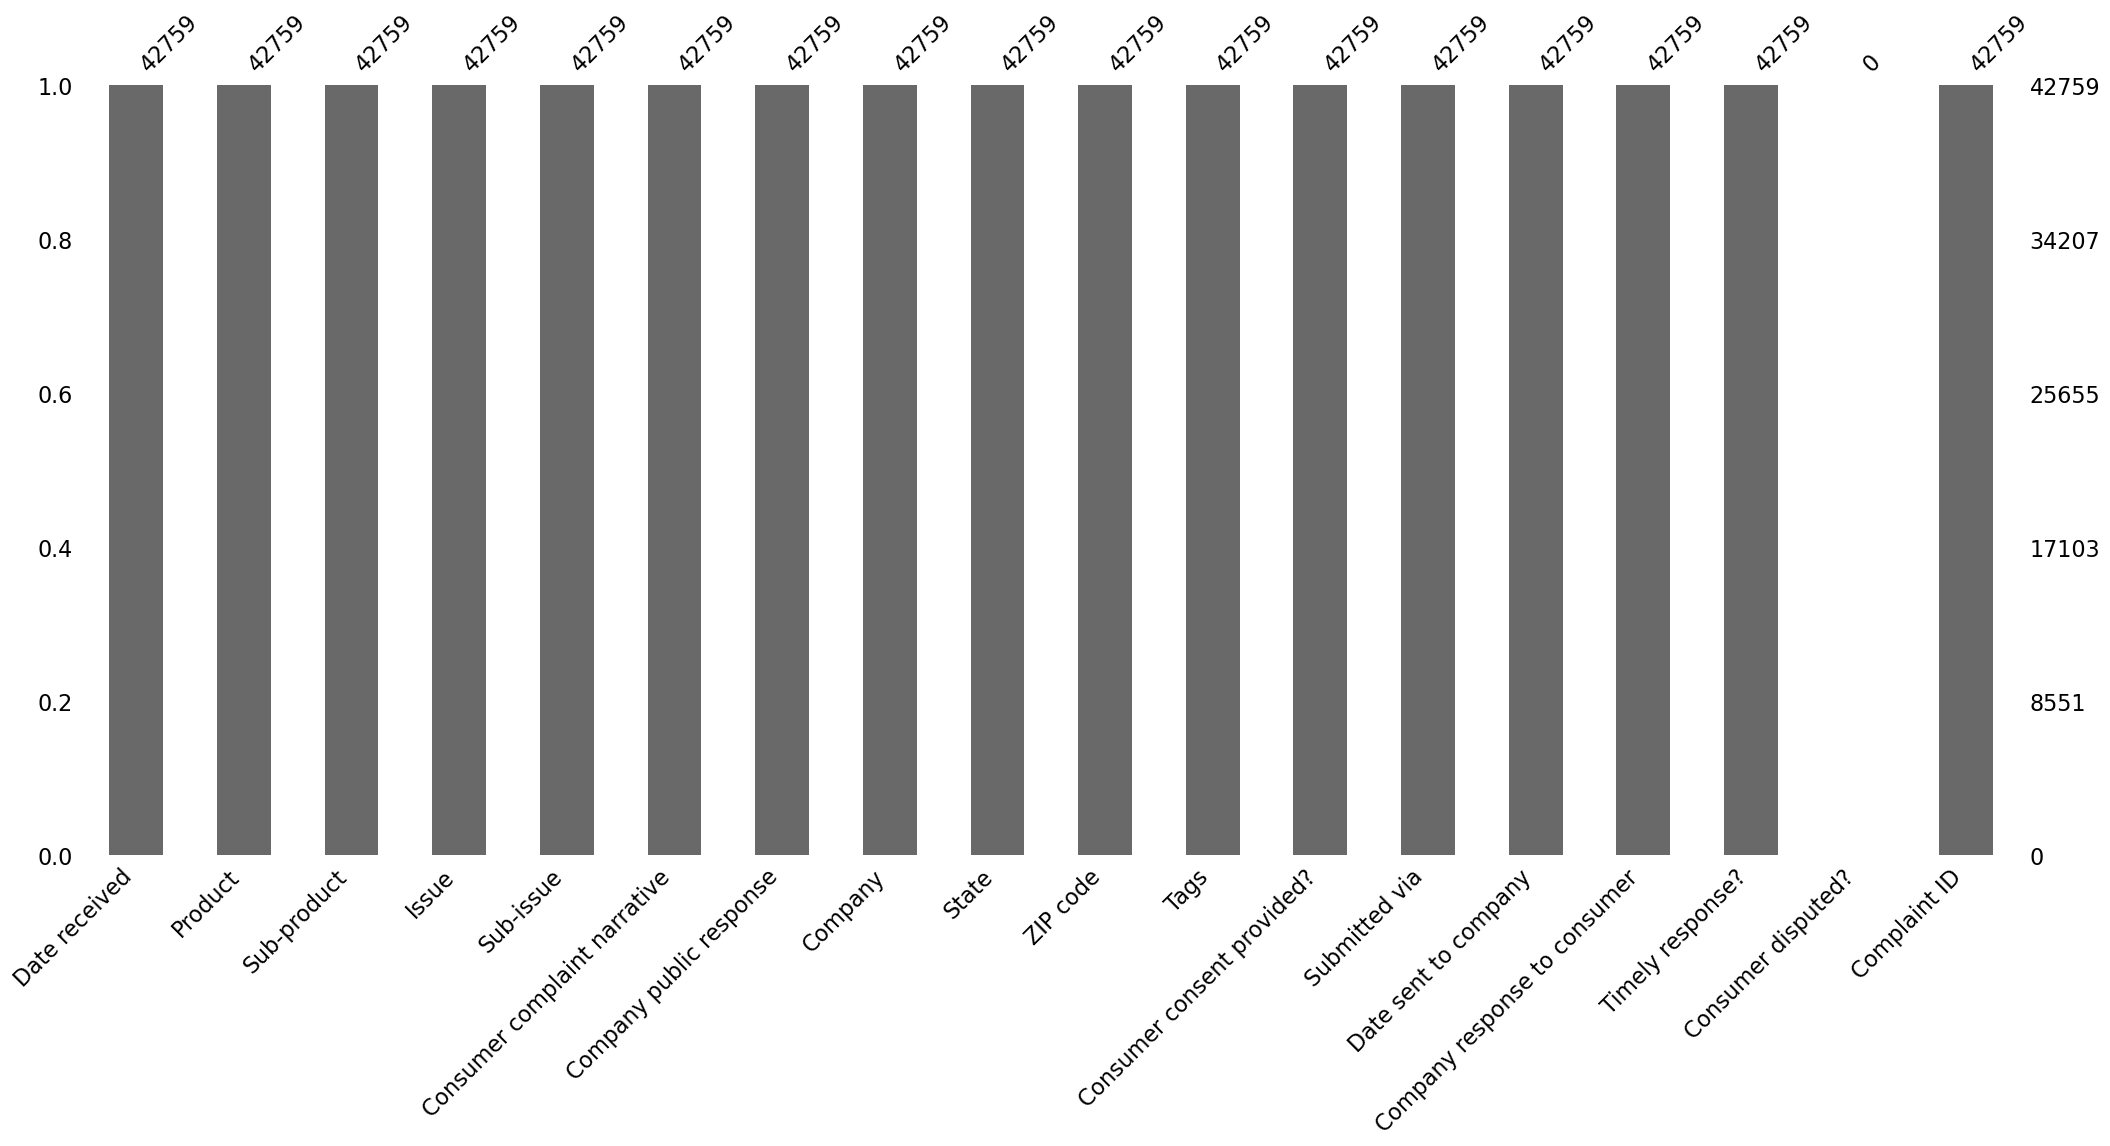

In [102]:
msno.bar(df)

In [103]:
df.drop('Consumer disputed?', axis = 1, inplace=True)

In [104]:
df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,6/1/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,FactorTrust run by XXXX have another consumer ...,None,Factor Trust,OH,44708,None,Consent provided,Web,6/1/23,Closed with explanation,Yes,7059212
1,6/1/23,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,"To Whom It May Concern, I purchased an XXXX a...",None,GOLDMAN SACHS BANK USA,CA,92308,Older American,Consent provided,Web,6/1/23,Closed with explanation,Yes,7059423


In [105]:
##Remove the punctuation in consumer complaint narrative fields
def remove_punc(text):
    reg = r'[^\w\s]'
    return re.sub(reg, '', text)

df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(remove_punc)

In [106]:
stop_words = set(stopwords.words('english'))

pre_process = ' '.join(df['Consumer complaint narrative'])
words = word_tokenize(pre_process)
words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]


bigram_list = list(bigrams(words))
trigram_list = list(trigrams(words))


bigram_freq = FreqDist(bigram_list)
trigram_freq = FreqDist(trigram_list)


print("Top 10 most common bigrams:")
print(bigram_freq.most_common(10))

print("\nTop 10 most common trigrams:")
print(trigram_freq.most_common(10))

Top 10 most common bigrams:
[(('xxxx', 'xxxx'), 551642), (('credit', 'report'), 24984), (('xxxx', 'xxxxxxxx'), 19170), (('xxxxxxxx', 'xxxx'), 18490), (('consumer', 'reporting'), 17712), (('reporting', 'agency'), 16522), (('usc', 'section'), 14041), (('xxxx', 'account'), 12676), (('credit', 'reporting'), 11975), (('consumer', 'report'), 10050)]

Top 10 most common trigrams:
[(('xxxx', 'xxxx', 'xxxx'), 462535), (('consumer', 'reporting', 'agency'), 15846), (('xxxx', 'xxxxxxxx', 'xxxx'), 12013), (('xxxxxxxx', 'xxxx', 'xxxx'), 11686), (('xxxx', 'xxxx', 'xxxxxxxx'), 11510), (('states', 'consumer', 'reporting'), 8522), (('fair', 'credit', 'reporting'), 8503), (('credit', 'reporting', 'act'), 8423), (('usc', 'section', 'states'), 8182), (('xxxx', 'xxxx', 'balance'), 7758)]


In [107]:
top_bigram = [item[0] for item in bigram_freq.most_common(10)]
top_trigram = [item[0] for item in trigram_freq.most_common(10)]

def remove_frequent_phrases(tokens, top_bigram, top_trigram):
    new_tokens = []
    i = 0
    while i < len(tokens):
        # Try to match trigrams first
        trigram = tuple(tokens[i:i + 3])
        bigram = tuple(tokens[i:i + 2])
        
        if trigram in top_trigram:
            i += 3  # Skip these tokens
        elif bigram in top_bigram:
            i += 2  # Skip these tokens
        else:
            new_tokens.append(tokens[i])
            i += 1  # Move to next token
            
    return ''.join(new_tokens)  # Joining the tokens back into a cleaned narrative


df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(lambda x: remove_frequent_phrases(x, top_bigram, top_trigram))

In [108]:
df['Consumer complaint narrative']

0        FactorTrust run by XXXX have another consumer ...
1        To Whom It May Concern I purchased an XXXX  at...
2        Hello My name is XXXX XXXX \n\nI am trying to ...
3        n accordance with the fair credit Reporting ac...
4        I reviewed my Consumer Reports and noticed tha...
                               ...                        
42754    I had called and talked to one of the customer...
42755    The following Inquiries are NOT mine and i nev...
42756    XXXX XXXX XXXX  XXXX or XXXX XXXX XXXX XXXX Th...
42757    I took out a personal loan with XXXX XXXX and ...
42758    I told the XXXX XXXX XXXX at XXXX to reinvesti...
Name: Consumer complaint narrative, Length: 42759, dtype: object

In [109]:
def remove_stop_words(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    preprocessed_text = ' '.join(words)
    return preprocessed_text

df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(remove_stop_words)

In [121]:
non_sense = []

def remove_non_sense(text):
    pattern = r'XX+'
    return re.sub(pattern, '', text)

df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(remove_non_sense)

In [122]:
def preprocess_text(text):
    words = word_tokenize(text)
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    lemmatized_text = ' '.join(lemmatized_words)
    return stemmed_words, lemmatized_words


df['Stemmed Text'], df['Lemmatized Text'] = zip(*df['Consumer complaint narrative'].apply(preprocess_text))

In [123]:
df[['Stemmed Text', 'Lemmatized Text']]

,Stemmed Text,Lemmatized Text
0,"[factortrust, run, anoth, consum, report, copi...","[FactorTrust, run, another, consumer, report, ..."
1,"[may, concern, purchas, ca, repres, card, paym...","[May, Concern, purchased, Ca, represented, car..."
2,"[hello, name, tri, sell, home, md, made, payme...","[Hello, name, trying, sell, home, MD, made, pa..."
3,"[n, accord, fair, credit, report, act, account...","[n, accordance, fair, credit, Reporting, act, ..."
4,"[review, consum, report, notic, late, payment,...","[reviewed, Consumer, Reports, noticed, late, p..."
...,...,...
42754,"[call, talk, one, custom, care, rep, want, pay...","[called, talked, one, customer, care, rep, wan..."
42755,"[follow, inquiri, mine, never, gave, permiss, ...","[following, Inquiries, mine, never, gave, perm..."
42756,"[balanc, 100000, account, open, account, open,...","[balance, 100000, account, opened, account, op..."
42757,"[took, person, loan, illeg, charg, interest, r...","[took, personal, loan, illegally, charged, int..."


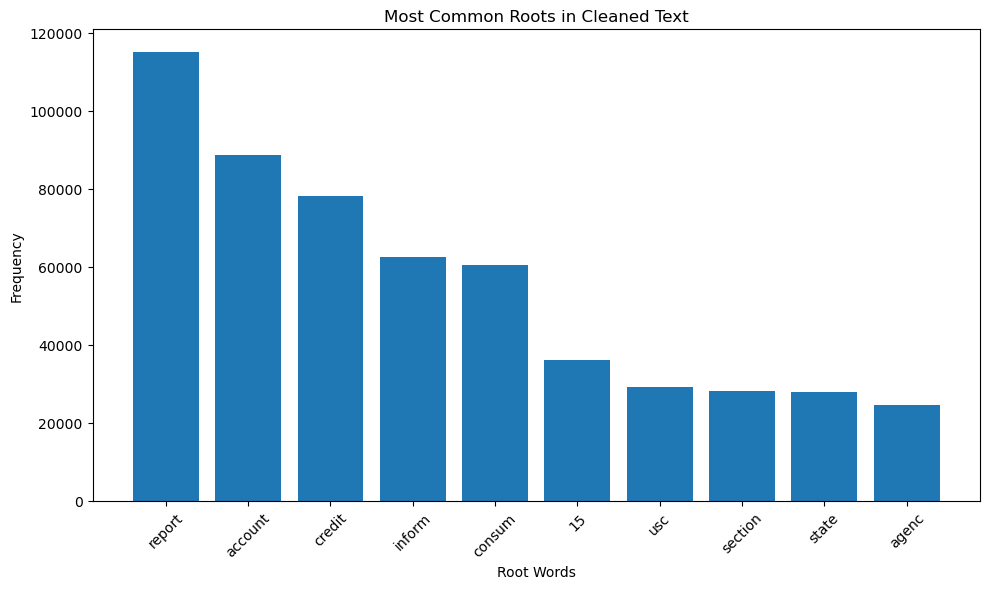

In [124]:
from collections import Counter

cleaned_words_stemmed = [stem for stems_list in df['Stemmed Text'] for stem in stems_list]
word_freq = Counter(cleaned_words_stemmed)
most_common_roots = word_freq.most_common(10)  
roots, frequencies = zip(*most_common_roots)


plt.figure(figsize=(10, 6))
plt.bar(roots, frequencies)
plt.xlabel('Root Words')
plt.ylabel('Frequency')
plt.title('Most Common Roots in Cleaned Text')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [1]:
# What are the top 10 most frequent consumer complaint topics based on product:

Text(0, 0.5, 'Product Level Topics')

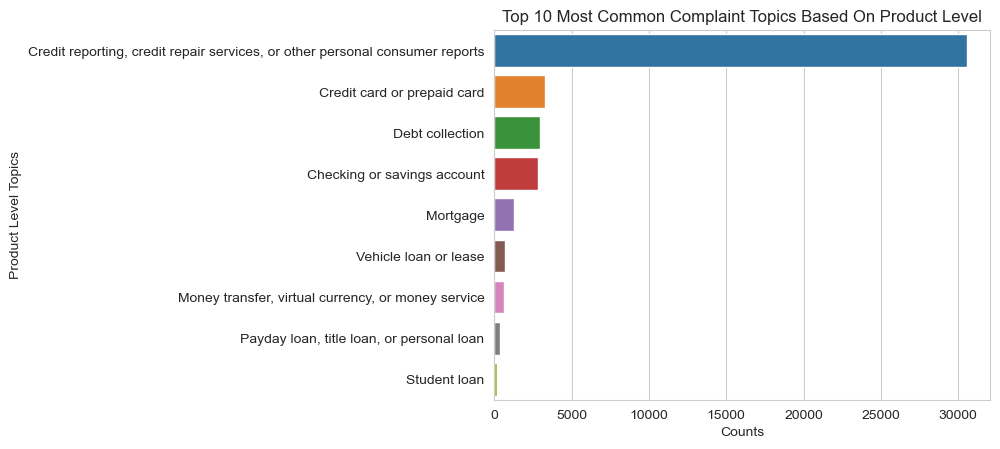

In [151]:
product_topics = df['Product'].value_counts().nlargest(10)

sns.set_style('whitegrid')
sns.barplot(x=product_topics.values, y=product_topics.index)
plt.title('Top 10 Most Common Complaint Topics Based On Product Level')
plt.xlabel('Counts')
plt.ylabel('Product Level Topics')

In [ ]:
# 2.2 Top 10 most common consumer complaint topics based on sub-product:

Text(0, 0.5, 'Sub - Product Level Topics')

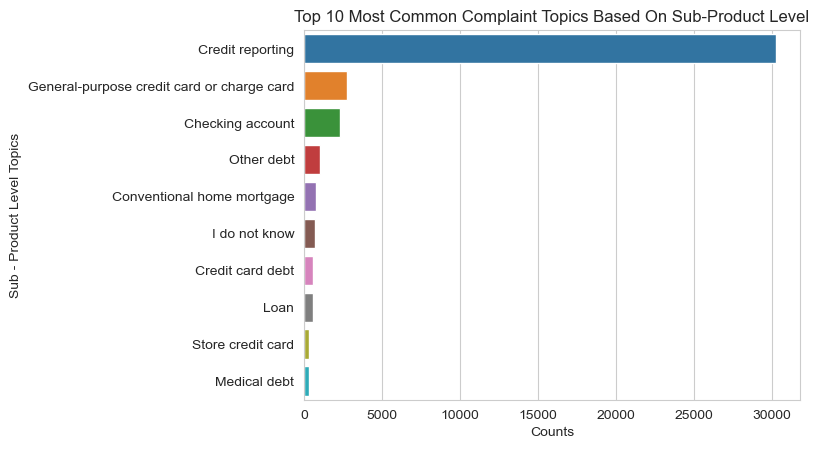

In [152]:
sub_product_topics = df['Sub-product'].value_counts().nlargest(10)

sns.barplot(x=sub_product_topics.values, y=sub_product_topics.index)
plt.title('Top 10 Most Common Complaint Topics Based On Sub-Product Level')
plt.xlabel('Counts')
plt.ylabel('Sub - Product Level Topics')

In [ ]:
# 2.3 Top 10 most common consumer complaint topics based on product:

Text(0, 0.5, 'Issue Level Topics')

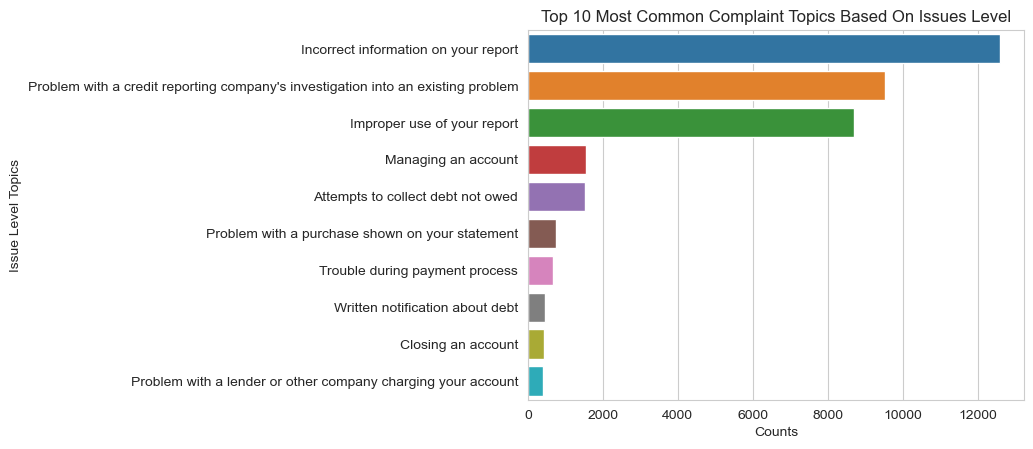

In [155]:
issue_topics = df['Issue'].value_counts().nlargest(10)

sns.barplot(x=issue_topics.values, y=issue_topics.index)
plt.title('Top 10 Most Common Complaint Topics Based On Issues Level')
plt.xlabel('Counts')
plt.ylabel('Issue Level Topics')

In [158]:
# 3.1 Assign Sentiment score on a 1-5 scale

In [157]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(stem_list):
    stemmed_text = ' '.join(stem_list)
    return analyzer.polarity_scores(stemmed_text)['compound']


df['Sentiment Score'] = df['Stemmed Text'].apply(get_sentiment_score)


def assign_sentiment(score):
    if score < -0.5:
        return 1
    elif -0.5 <= score < -0.1:
        return 2
    elif -0.1 <= score < 0.1:
        return 3
    elif 0.1 <= score < 0.5:
        return 4
    else:
        return 5

df['Sentiment Score (1-5)'] = df['Sentiment Score'].apply(assign_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sunnypzz/nltk_data...


In [161]:
df[['Consumer complaint narrative','Sentiment Score (1-5)']]

,Consumer complaint narrative,Sentiment Score (1-5)
0,FactorTrust run another consumer report copie...,2
1,May Concern purchased Ca represented ca...,2
2,Hello name trying sell home MD made pa...,2
3,n accordance fair credit Reporting act Accoun...,5
4,reviewed Consumer Reports noticed late paymen...,5
...,...,...
42754,called talked one customer care reps wanted pa...,5
42755,following Inquiries mine never gave permission...,4
42756,balance 100000 account opened account...,2
42757,took personal loan illegally charged interes...,5


In [162]:
# 3.2 Building Model predicting the Sentiment Score

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Step 1: Feature Extraction
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Consumer complaint narrative'])

rf_classifier = RandomForestClassifier()


X_train, X_test, y_train, y_test = train_test_split(X.toarray(), df['Sentiment Score (1-5)'], test_size = 0.33, random_state = 42)

rf_classifier.fit(X_train, y_train)

accuracy = lr.score(X_test, y_test)
print(f"Accuracy: {accuracy}\n")

Accuracy: 0.8277939196371625



In [208]:
for sentiment in range(1, 6):
    # Create and train a RandomForestClassifier for the current sentiment rating
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train == sentiment)  # Convert to binary classification for the current sentiment rating
    
    # Get the feature importances for the current sentiment rating
    feature_importances = rf_classifier.feature_importances_
    
    # Get the indices of the top 10 features with the highest importances for the current sentiment rating
    top_indices = feature_importances.argsort()[::-1][:10]
    
    # Get the corresponding feature names for the current sentiment rating
    top_feature_names = [vectorizer.get_feature_names_out()[idx] for idx in top_indices]
    
    # Store the top features for the current sentiment rating in the dictionary
    top_features[sentiment] = top_feature_names

# Display the top features for each sentiment rating
for sentiment, features in top_features.items():
    print(f"Sentiment Rating {sentiment}: {', '.join(features)}")

Sentiment Rating 5: credit, fair, act, report, reporting, fraud, interest, thank, bureaus, debt
Sentiment Rating 1: fraud, debt, credit, stress, victim, theft, identity, report, scam, alleged
Sentiment Rating 2: credit, goods, report, error, debt, exchanges, information, complaint, coming, victim
Sentiment Rating 3: credit, attached, report, account, debt, late, never, consumer, information, complaint
Sentiment Rating 4: credit, 1681c, third, containing, report, falsely, crimes, uploaded, convictions, sure


In [211]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), df['Sentiment Score (1-5)'], test_size = 0.33, random_state = 42)

rf_classifier.fit(X_train, y_train)

# Choose 5 random consumer complaint narratives for demonstration
consumer_complaints = df['Consumer complaint narrative'].sample(n=5)

# Transform the consumer complaint narratives into feature vectors
consumer_complaints_X = vectorizer.transform(consumer_complaints)

# Make predictions for the sentiment of the consumer complaints using rf_classifier
predictions = rf_classifier.predict(consumer_complaints_X)

# Display the consumer complaints and their predicted sentiment ratings
for i, (complaint, prediction) in enumerate(zip(consumer_complaints, predictions)):
    print(f"\nConsumer Complaint {i+1}:")
    print(complaint)
    print(f"Predicted Sentiment Rating: {prediction}\n")


Consumer Complaint 1:
Yes filed complaint Bank years ago reason company responded one complaint auto loan went arbitration Bank arbitration company said sense like small case couldnt get Attorney help according Law firm hired Bank according several Managers Supervisors Tellers  District Managers firm wasnt one Banks Firms never told made aware case sent Arbitrary proof form Bank Statements Bank receipts transactions anything else show one checking auto loan something Bank called secondary Checking account everything received branches listed SIDE CHECKING according several employees CHECKINGSavings accounts branches opened without customers permission knowledge branches make quotes order stay open fact Bank opened 4 different credit cards 2 CHECKING 3 4 SAVINGS ACCOUNTS account different names use social security number else would accounts cards coming house putting cash accounts paying items sent business first complaint items credit reports Attorney firm claimed accounts Banks first 

Consumer Complaint 1 (Predicted Sentiment Rating: 5): This complaint involves a complex issue with a bank, including unauthorized transactions and difficulties in resolving the matter. The predicted sentiment rating of 5 aligns with the frustration expressed by the consumer in the complaint.

Consumer Complaint 2 (Predicted Sentiment Rating: 1): The complaint concerns a fraudulent case involving a bank and expresses disappointment with the handling of the case. The predicted sentiment rating of 1, indicating a very negative sentiment, is appropriate given the consumer's dissatisfaction.

Consumer Complaint 3 (Predicted Sentiment Rating: 2): This complaint revolves around disputes with credit bureaus regarding credit information. The predicted sentiment rating of 2 (negative sentiment) is reasonable as the consumer is frustrated with credit reporting issues.

Consumer Complaint 4 (Predicted Sentiment Rating: 5): The complaint addresses fraudulent personal information and identity theft, which can be highly distressing. The predicted sentiment rating of 5 is appropriate given the severity of the situation and the urgency expressed by the consumer.

Consumer Complaint 5 (Predicted Sentiment Rating: 5): This concise complaint highlights bias in credit reporting agencies' refusal to delete identified transactions. The predicted sentiment rating of 5 is fitting as the consumer is concerned about privacy violations.